# Visualizing filters of a network trained to recognize metallicity from galaxy images
Here we're going to be following the [excellent blog post](https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030) by Fabio M. Graetz. Note that this code requires `torch` version 0.4 (even though technically `fastai` version 0.7 is incompatible)...

For `fastai` version 1.0, we may eventually want to look at something like [this deep dream example](https://github.com/kheyer/ML-DL-Projects/blob/master/Pytorch%20Deep%20Dream/dreaming.ipynb).

In [24]:
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *

PATH = os.path.abspath('..')
sys.path.append(f'/home/john/projects/convnet-demo/src')
from multiclass import *

print(torch.__version__)

0.4.1


# Load data and model

In [2]:
train_label_csv = f'{PATH}/catalogs/train.csv'
df = pd.read_csv(train_label_csv, index_col=0)

n = len(df)
val_idxs = get_cv_idxs(n, val_pct=0.2, seed=256)

In [3]:
arch = resnet34
sz = 128
bs = 128

# get data transformers and ClassifierData object (for regression)
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=4)

n_batch = len(data.trn_y) // bs

# initialize pretrained network
learn = ConvLearner.pretrained(arch, data)
learn.crit = rmse

/home/john/anaconda3/envs/fastai-v0.7_torch-v0.4/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/john/anaconda3/envs/fastai-v0.7_torch-v0.4/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [4]:
learn.load('resnet34-single_sz128-bs128')
learn.crit = rmse

In [5]:
fn = PATH + '/' + data.val_ds.fnames[0]
img = PIL.Image.open(fn); 

# Visualize filters

In [114]:
class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = nn.Parameter(output, requires_grad=True)
    def close(self):
        self.hook.remove()

In [118]:
class FilterVisualizer():
    def __init__(self, model, tfms, size=28, upscaling_steps=6, upscaling_factor=1.2):
        self.size, self.upscaling_steps, self.upscaling_factor = size, upscaling_steps, upscaling_factor
        self.model = model.eval()
        self.tfms = tfms
        set_trainable(self.model, False)

    def visualize(self, layer, filter_idx, lr=0.1, opt_steps=20, blur=None, is_resblock=True):
        sz = self.size
        img = np.uint8(np.random.uniform(0, 180, (sz, sz, 3)))/255  # generate random image
        if is_resblock:
            activations = SaveFeatures(list(self.model.children())[layer][2].conv2)  # register hook on the 2nd set of layers in 2nd conv filters in res block
        else:
            activations = SaveFeatures(list(self.model.children())[layer])

        for _ in range(self.upscaling_steps):  # scale the image up upscaling_steps times
            trn_tfms, val_tfms = tfms_from_model(model, sz)
            img_var = V(val_tfms(img)[None], requires_grad=True)  # convert image to Variable that requires grad
            optimizer = torch.optim.Adam([img_var], lr=lr, weight_decay=1e-6)
            for n in range(opt_steps):  # optimize pixel values for opt_steps times
                optimizer.zero_grad()
                self.model(img_var)
                loss = -activations.features[0, filter_idx].mean()
                loss.backward()
                optimizer.step()
            img = val_tfms.denorm(img_var.data.cpu().numpy()[0].transpose(1,2,0))
            self.output = img
            sz = int(self.upscaling_factor * sz)  # calculate new image size
            img = cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)  # scale image up
            if blur is not None: img = cv2.blur(img,(blur,blur))  # blur image to reduce high frequency patterns
        self.save(layer, filter_idx)
        activations.close()
        
    def save(self, layer, filter_idx):
        plt.imsave(f'../results/layer_{layer}/filter_{filter_idx}.jpg', np.clip(self.output, 0, 1))

In [116]:
layer = 7
filter_idx = 0

FV = FilterVisualizer(model, tfms, size=28, upscaling_steps=4, upscaling_factor=1.2)
FV.visualize(layer, filter_idx, blur=None)

Text(0.5,1,'layer 7, filter 0')

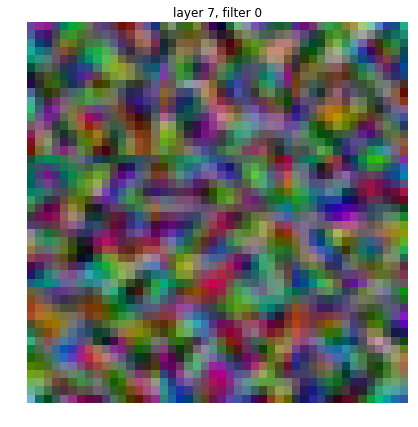

In [117]:
img = PIL.Image.open(f'../results/layer_{layer}/filter_{filter_idx}.jpg')
plt.figure(figsize=(7,7))
plt.imshow(img)
plt.axis('off')
plt.title(f'layer {layer}, filter {filter_idx}')

# Take a look around

In [66]:
model[7][2].conv2

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

Maybe let's just try a bunch of these...

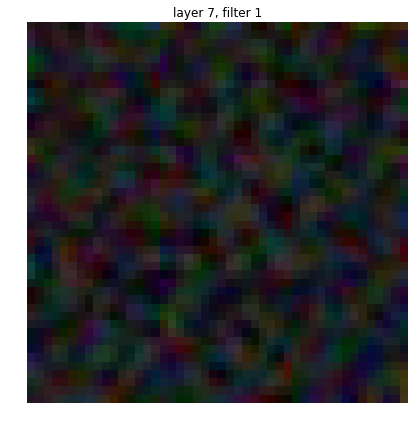

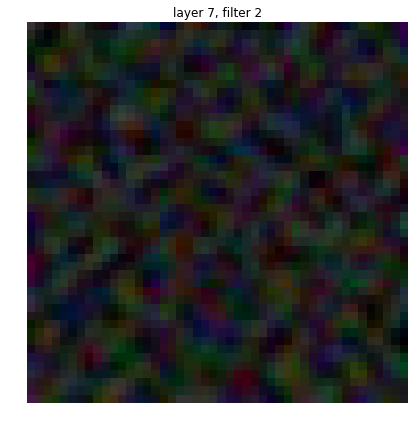

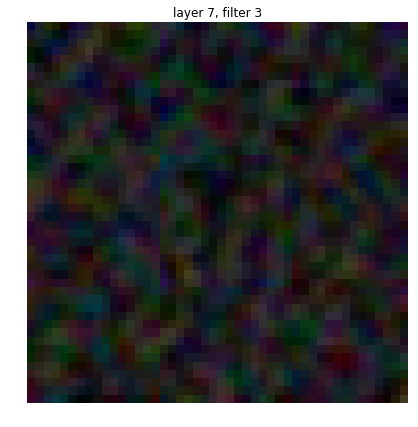

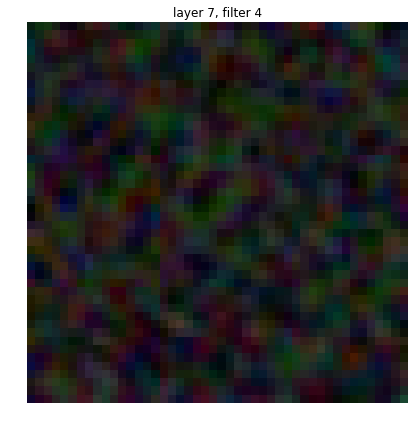

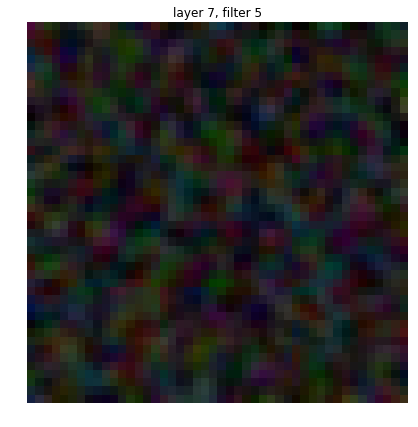

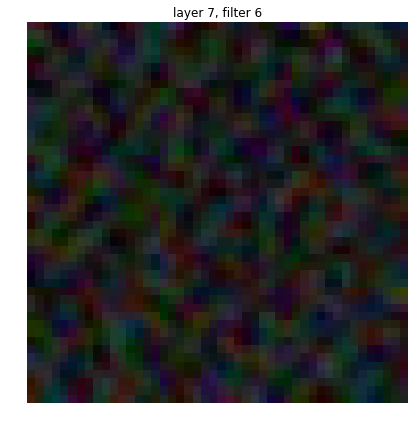

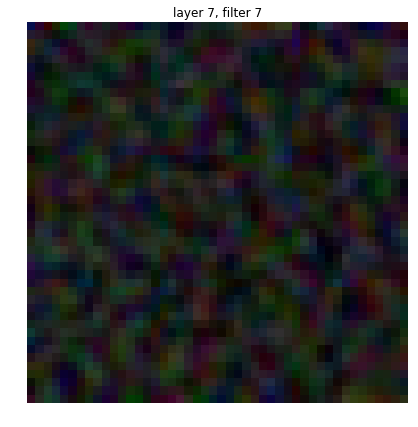

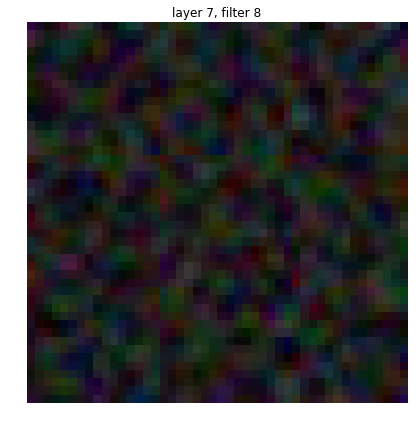

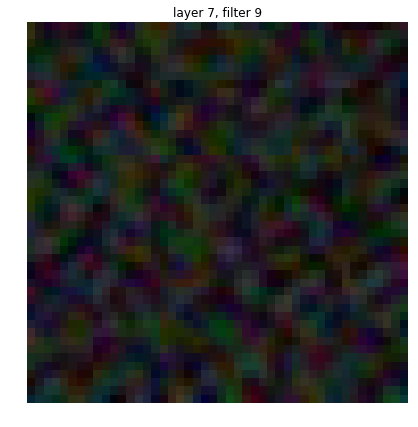

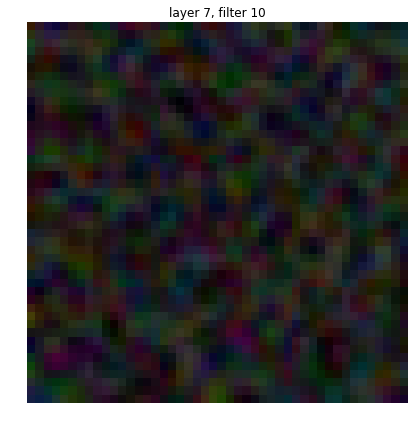

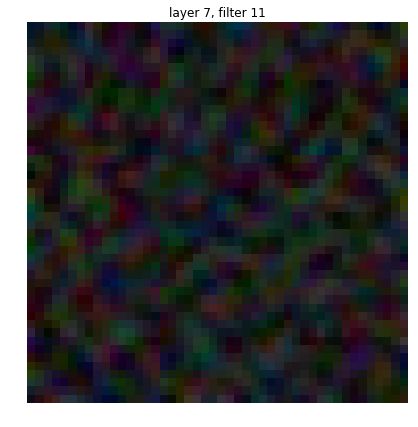

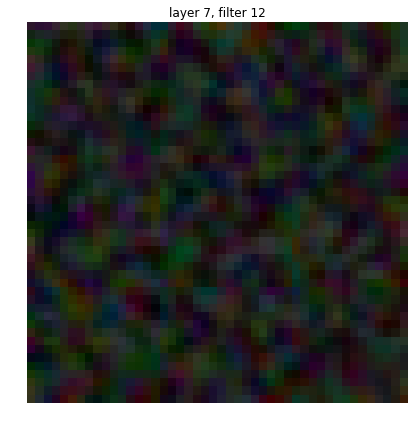

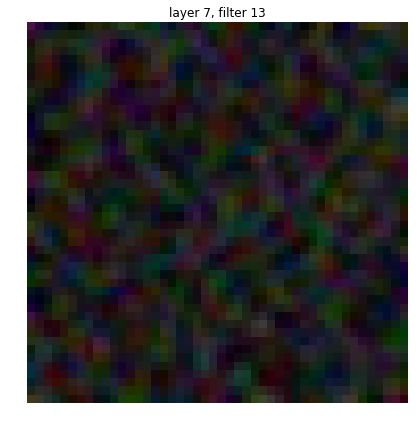

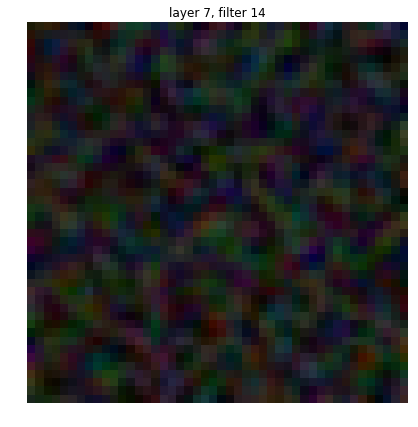

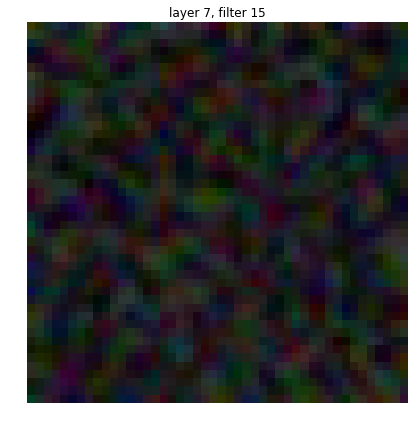

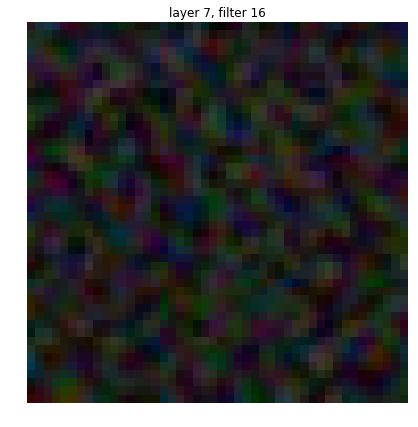

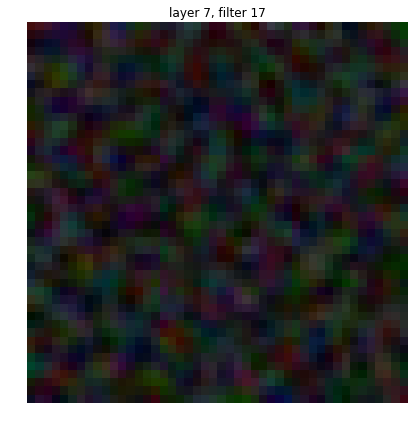

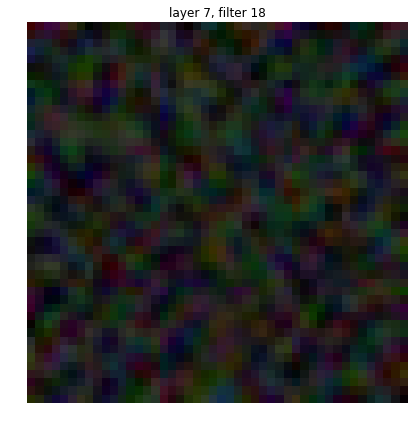

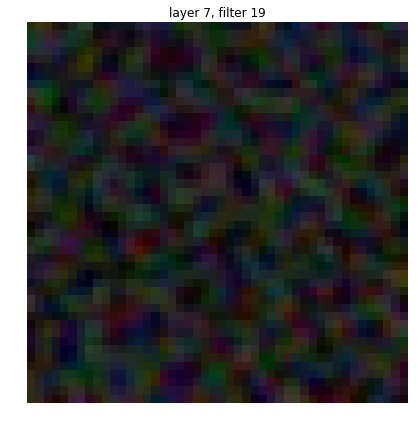

In [73]:
layer = 7

for filter_idx in range(1, 20):
    FV = FilterVisualizer(model, tfms, size=28, upscaling_steps=4, upscaling_factor=1.2)
    FV.visualize(layer, filter_idx, blur=None)

    img = PIL.Image.open(f'../results/layer_{layer}/filter_{filter_idx}.jpg')
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'layer {layer}, filter {filter_idx}')
    plt.show()

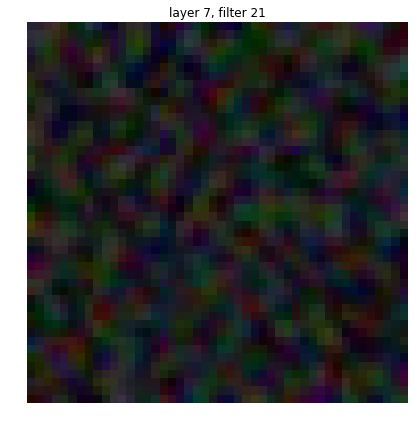

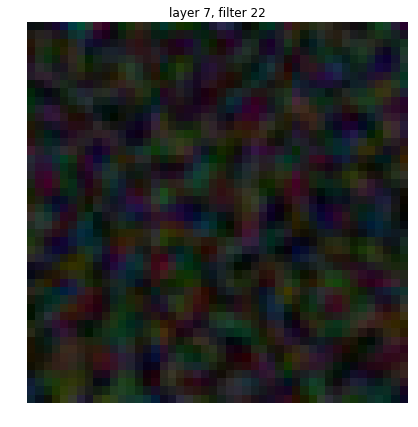

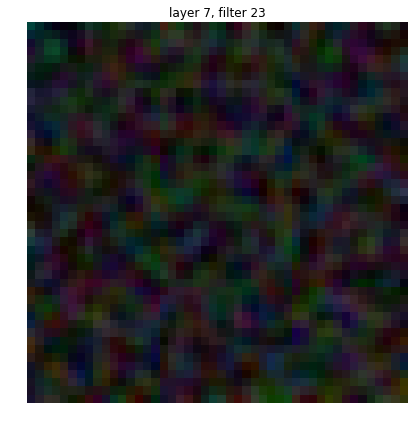

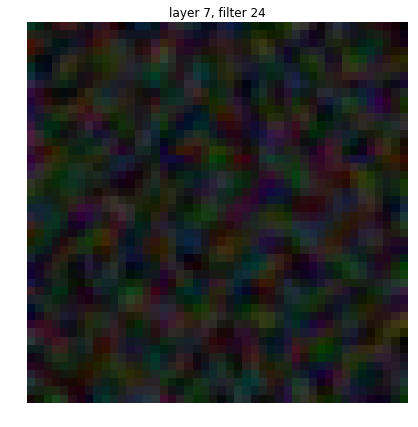

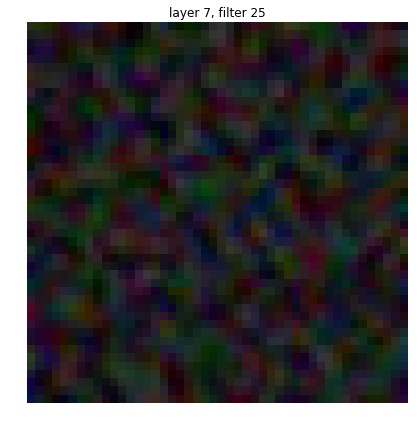

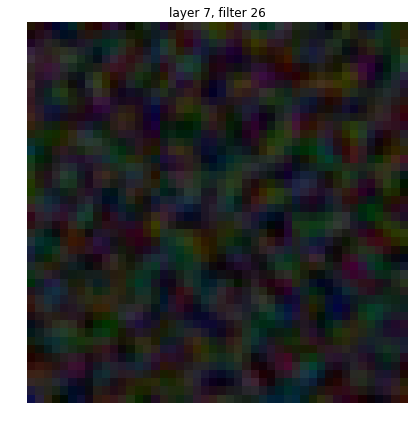

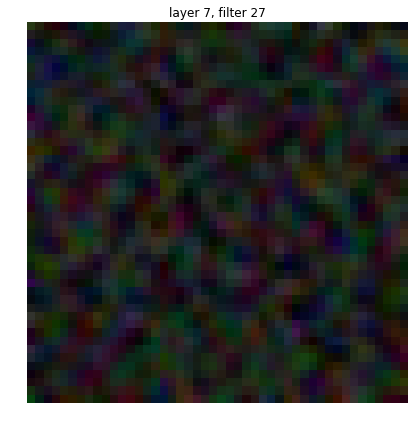

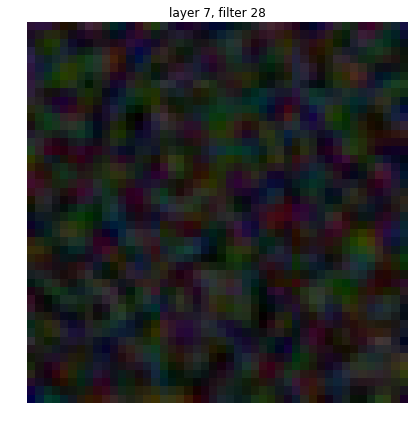

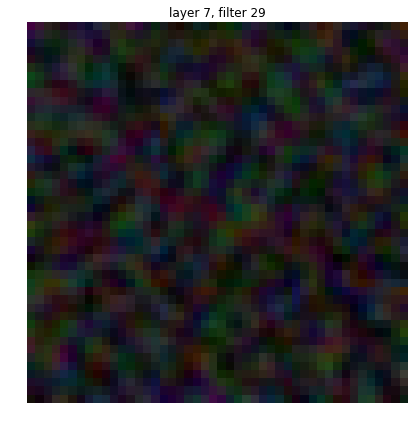

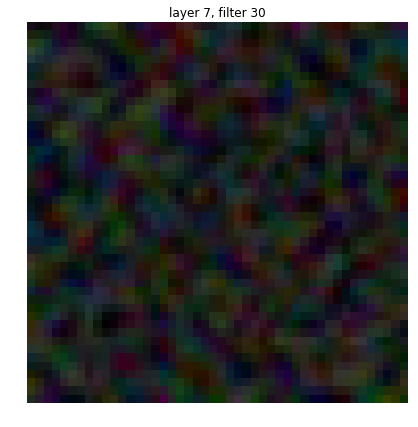

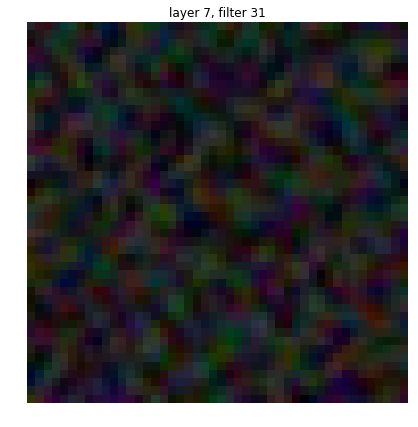

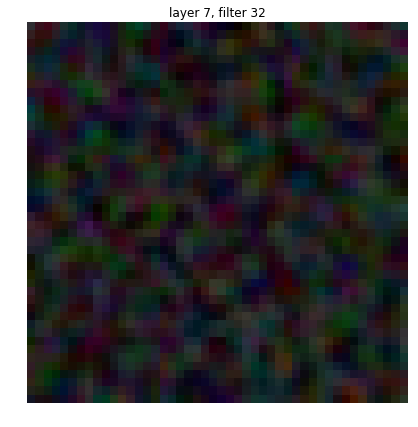

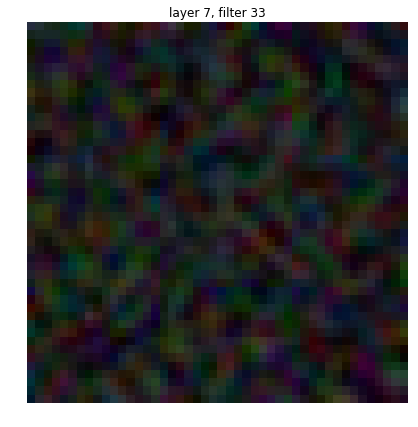

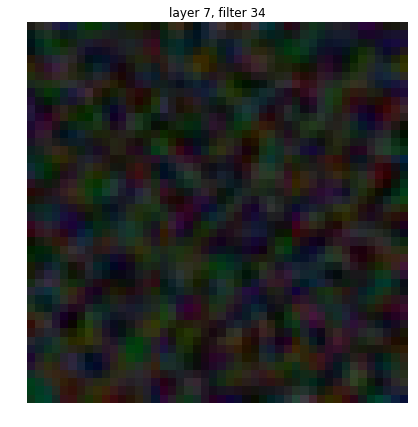

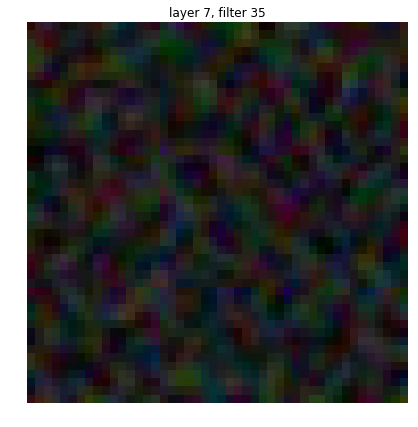

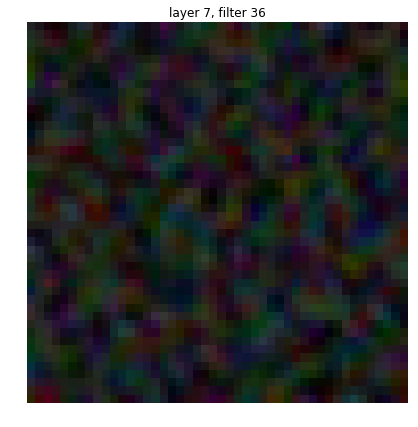

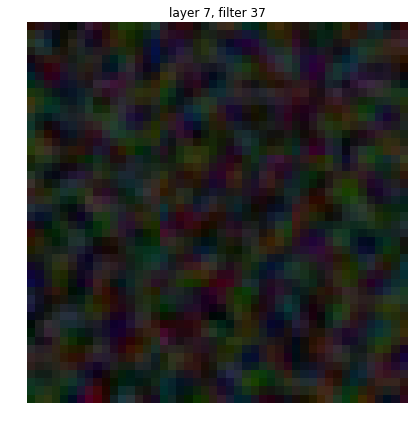

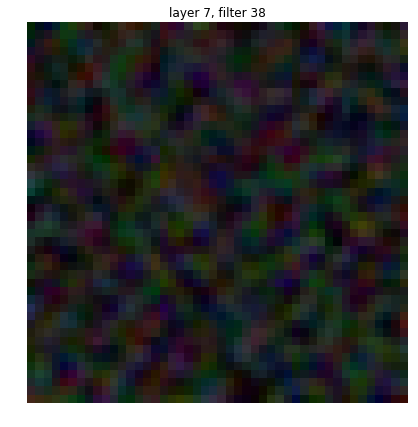

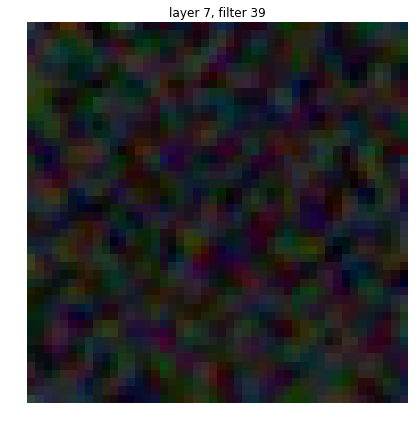

In [79]:
layer = 7

for filter_idx in range(21, 40):
    FV = FilterVisualizer(model, tfms, size=28, upscaling_steps=4, upscaling_factor=1.2)
    FV.visualize(layer, filter_idx, blur=None)

    img = PIL.Image.open(f'../results/layer_{layer}/filter_{filter_idx}.jpg')
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'layer {layer}, filter {filter_idx}')
    plt.show()

# Targeted search?

Maybe we need to rethink our strategy. It makes sense to first look at the filters that have highest activations from a typical image.

In [81]:
x,y = next(iter(data.val_dl))

In [92]:
layer = 7
layer_7_model = nn.Sequential(*children(model)[:layer+1])
layer_7_activations = layer_7_model(x)

In [93]:
layer_7_activations.shape

torch.Size([80, 512, 4, 4])

In [107]:
top_20_filters = list(reversed(layer_7_activations.numpy().mean(axis=(0,2,3)).argsort()))[:20]
top_20_filters

[78,
 90,
 398,
 221,
 417,
 494,
 20,
 379,
 146,
 438,
 488,
 320,
 120,
 361,
 205,
 505,
 167,
 164,
 53,
 51]

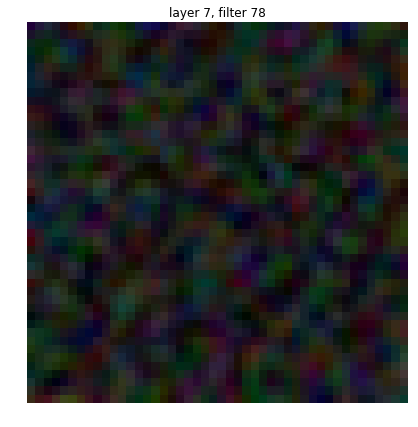

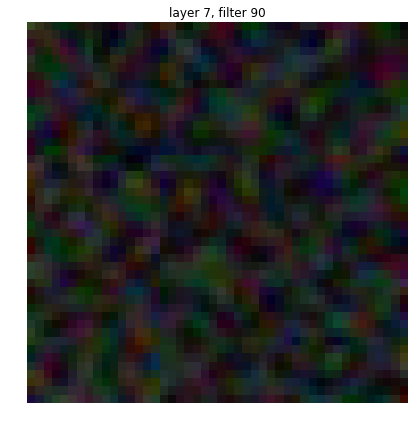

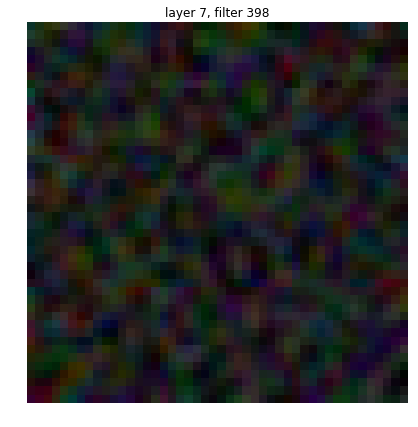

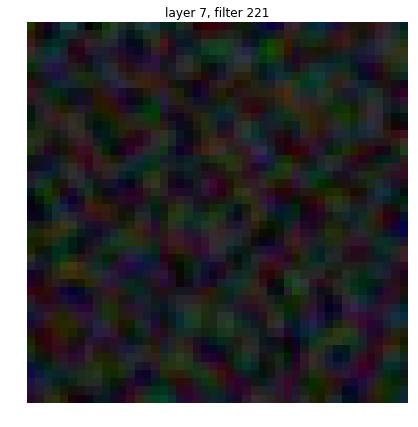

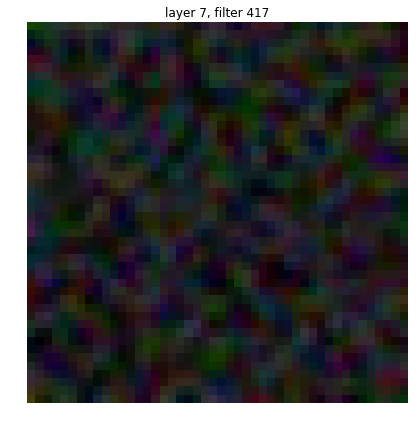

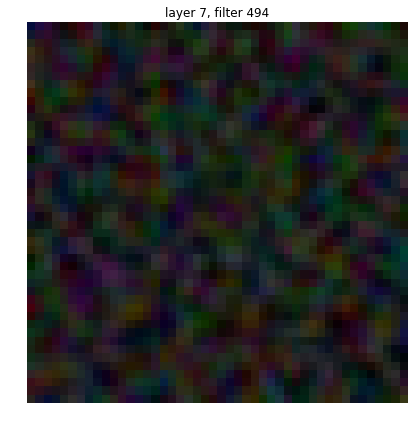

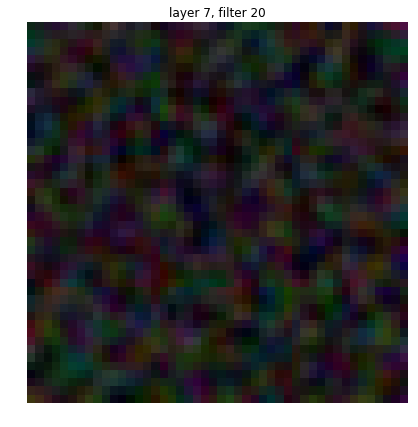

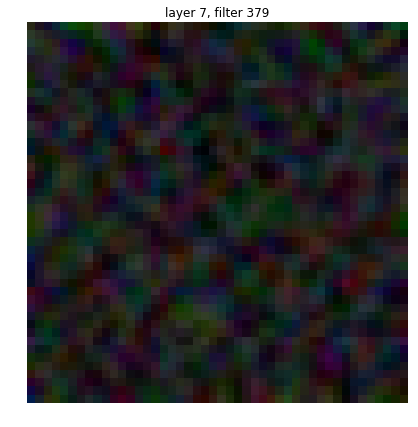

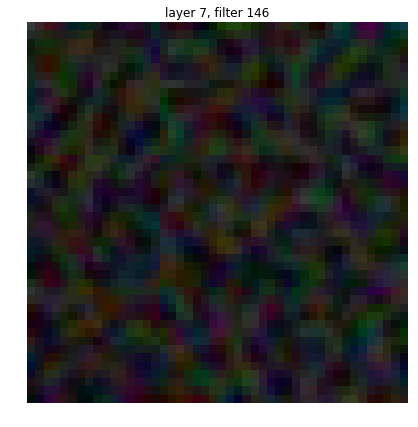

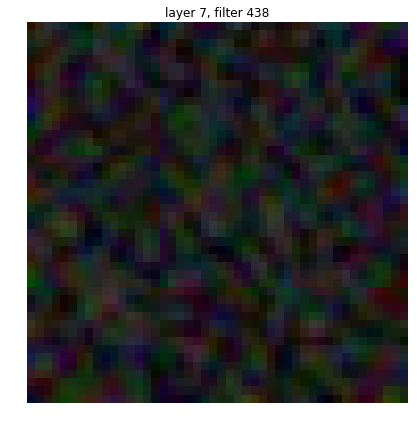

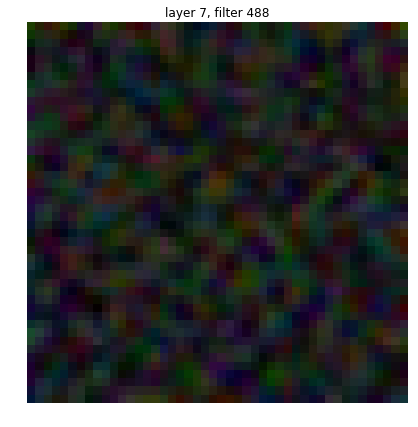

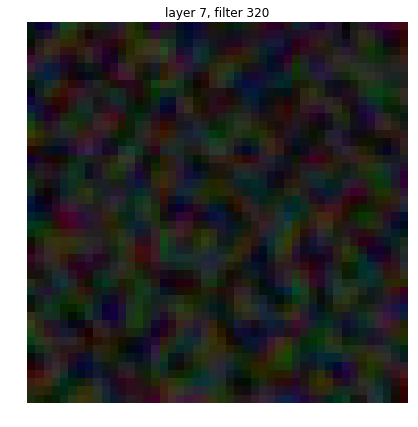

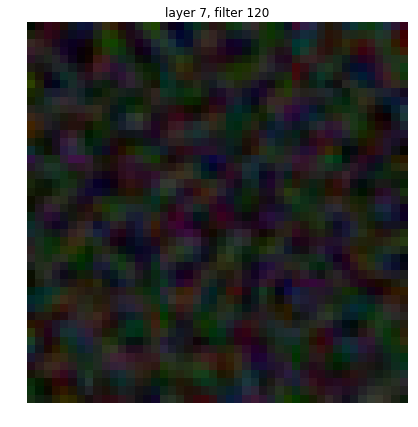

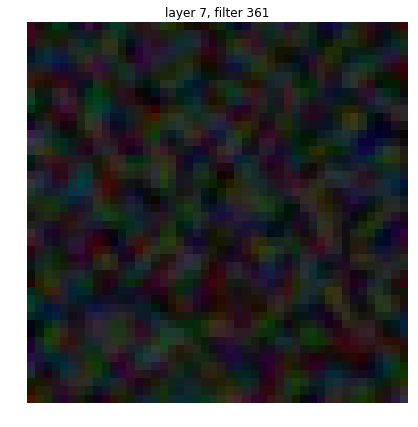

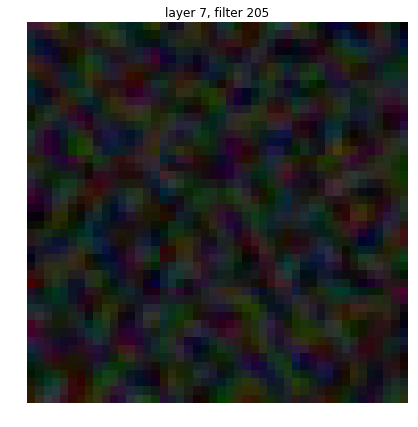

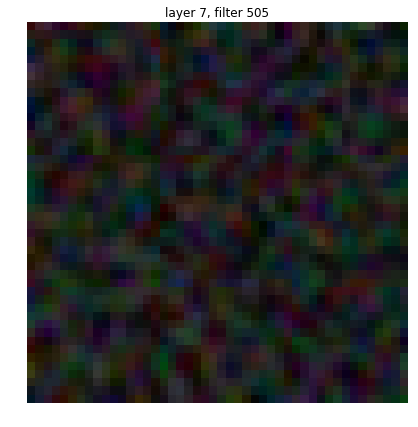

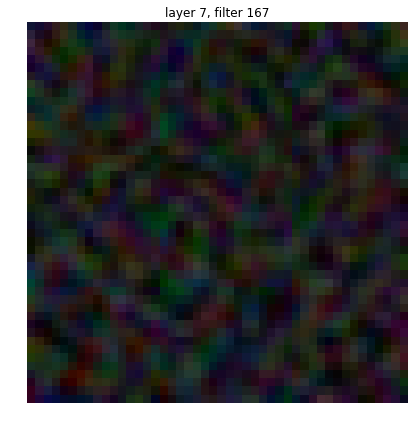

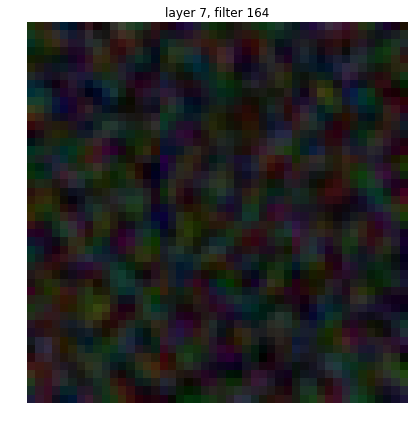

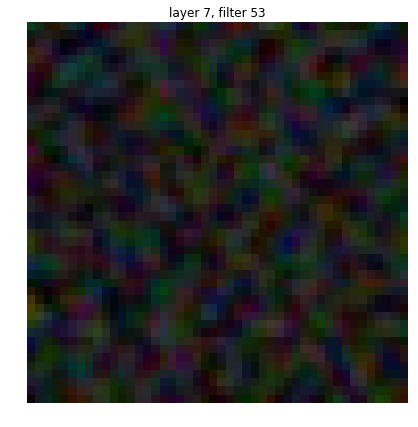

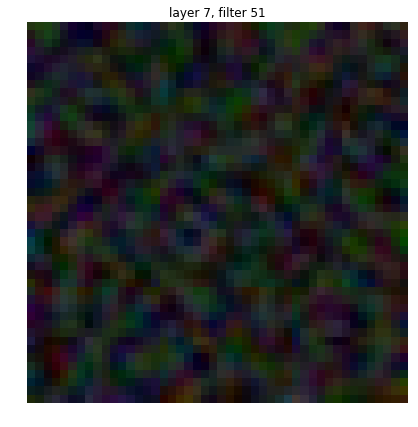

In [108]:
layer = 7

for filter_idx in top_20_filters:
    FV = FilterVisualizer(model, tfms, size=28, upscaling_steps=4, upscaling_factor=1.2)
    FV.visualize(layer, filter_idx, blur=None)

    img = PIL.Image.open(f'../results/layer_{layer}/filter_{filter_idx}.jpg')
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'layer {layer}, filter {filter_idx}')
    plt.show()

# Search earlier layers

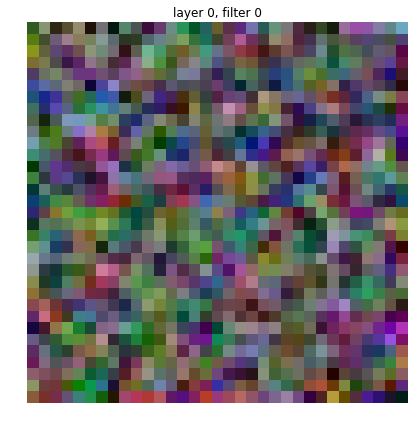

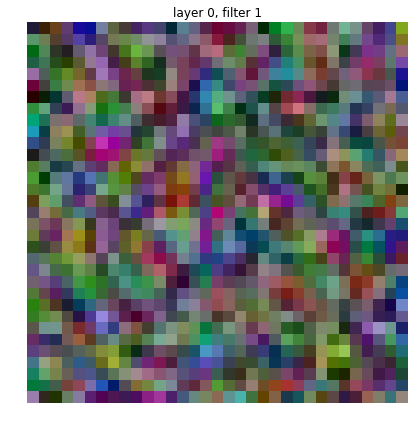

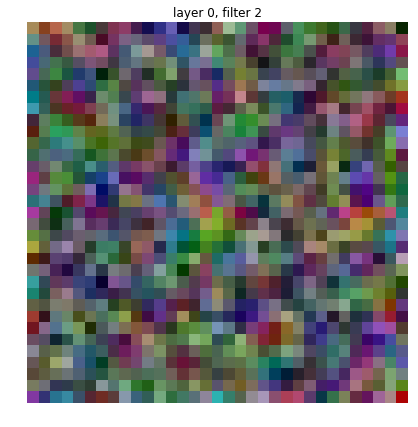

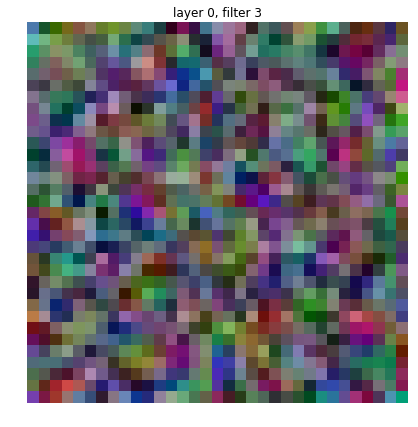

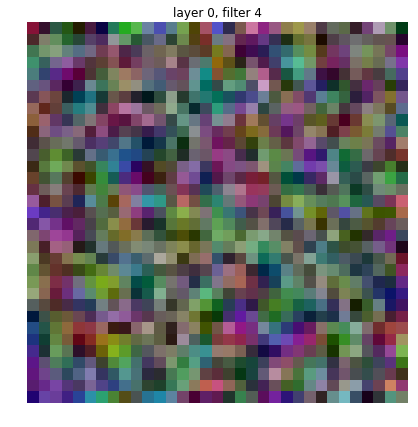

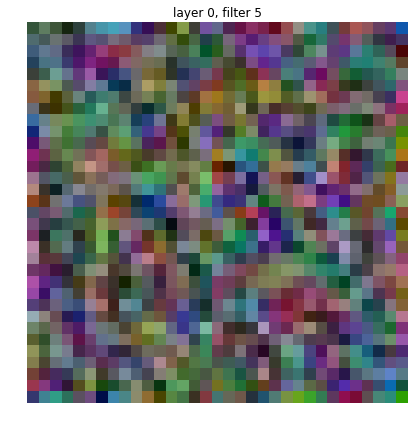

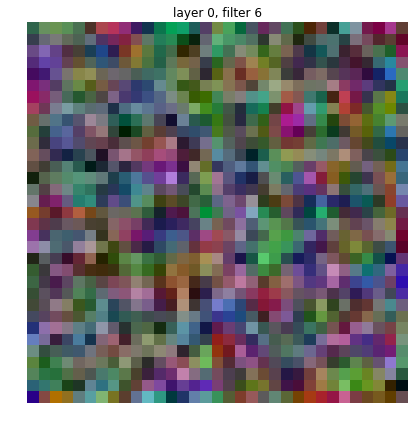

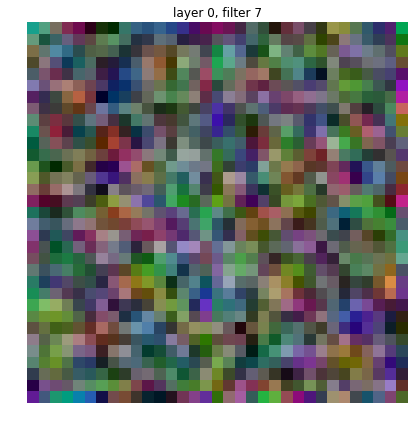

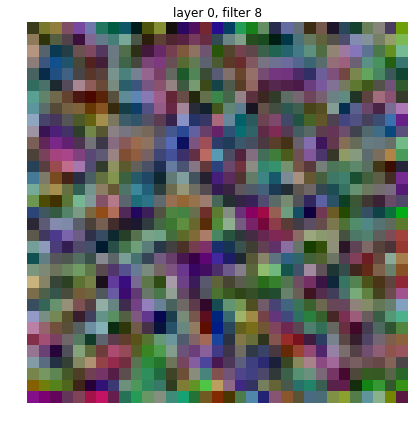

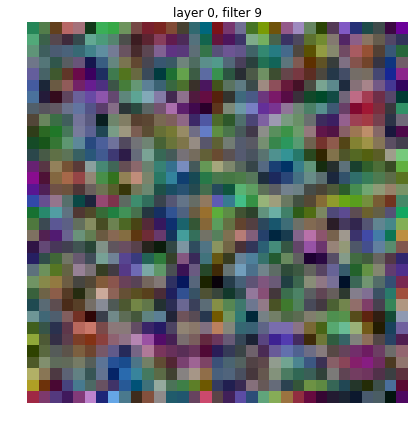

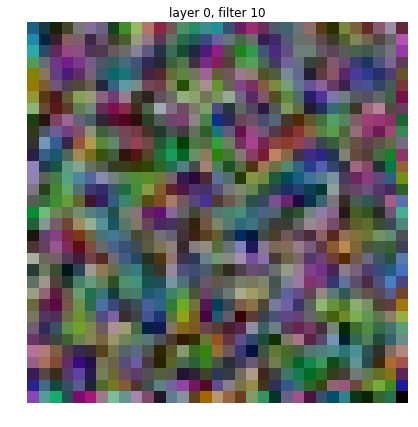

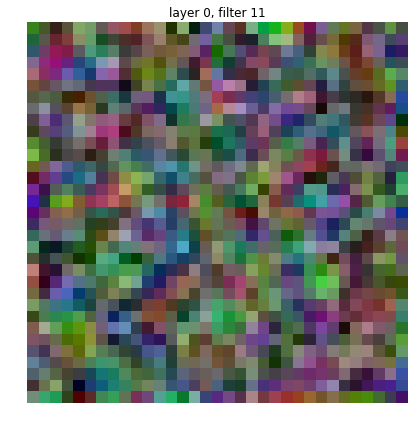

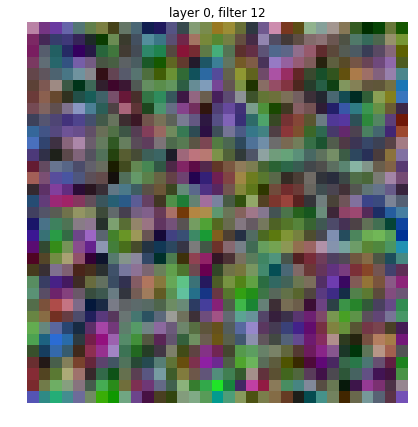

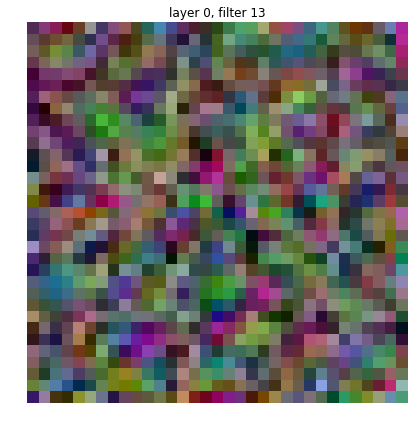

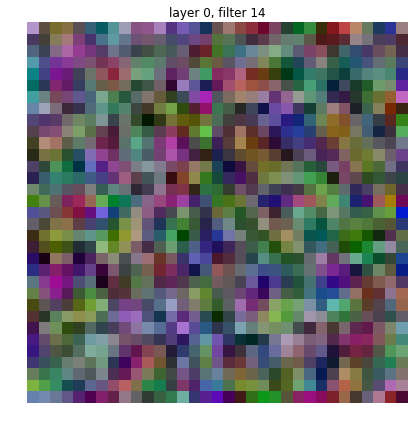

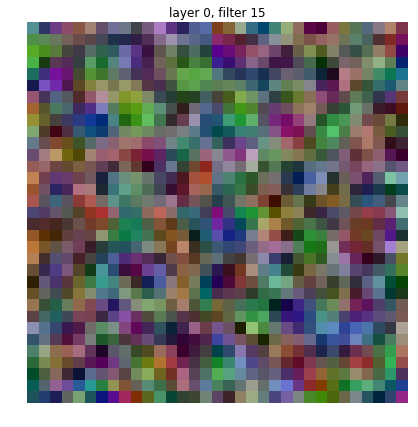

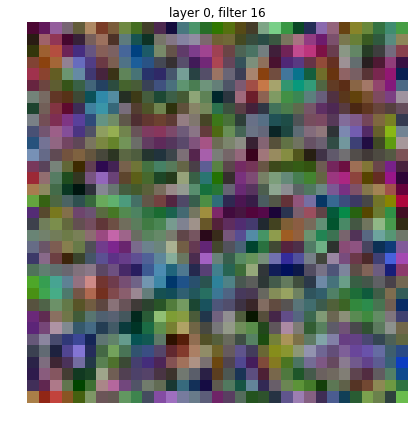

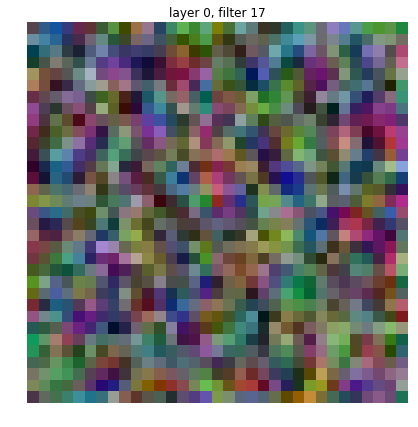

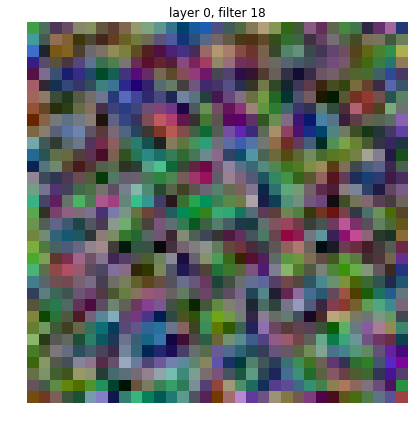

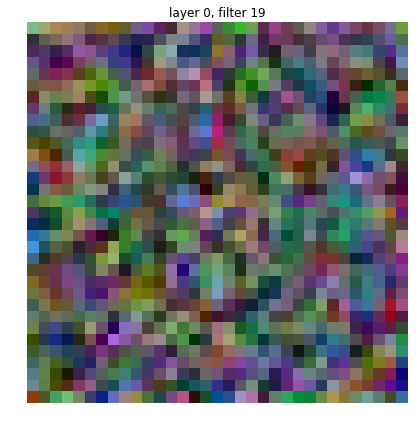

In [122]:
layer = 0

for filter_idx in range(0, 20):
    FV = FilterVisualizer(model, tfms, size=28, upscaling_steps=2, upscaling_factor=1.2)
    FV.visualize(layer, filter_idx, opt_steps=40, blur=None, is_resblock=False)

    img = PIL.Image.open(f'../results/layer_{layer}/filter_{filter_idx}.jpg')
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'layer {layer}, filter {filter_idx}')
    plt.show()

What the heck